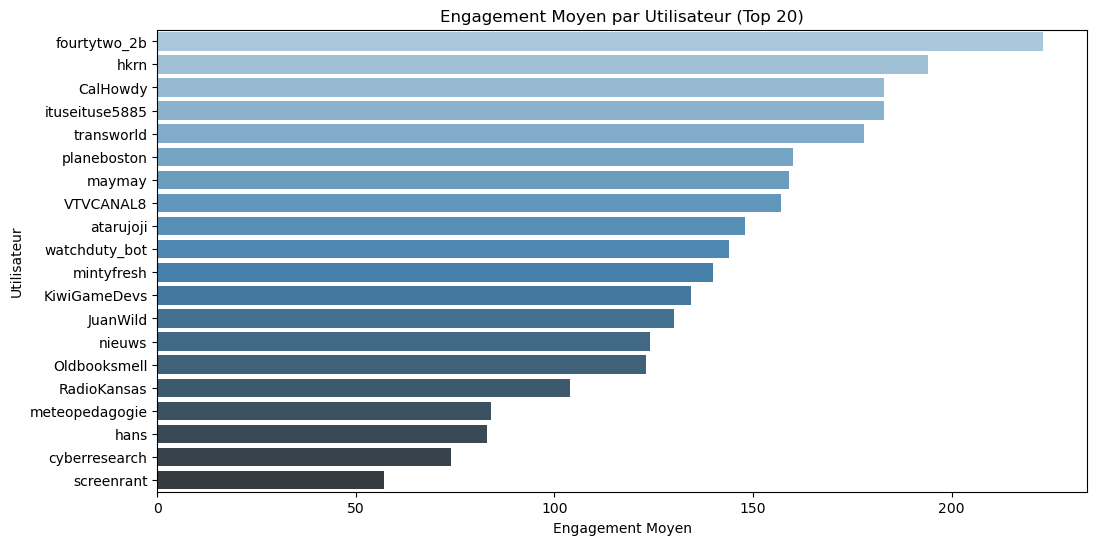

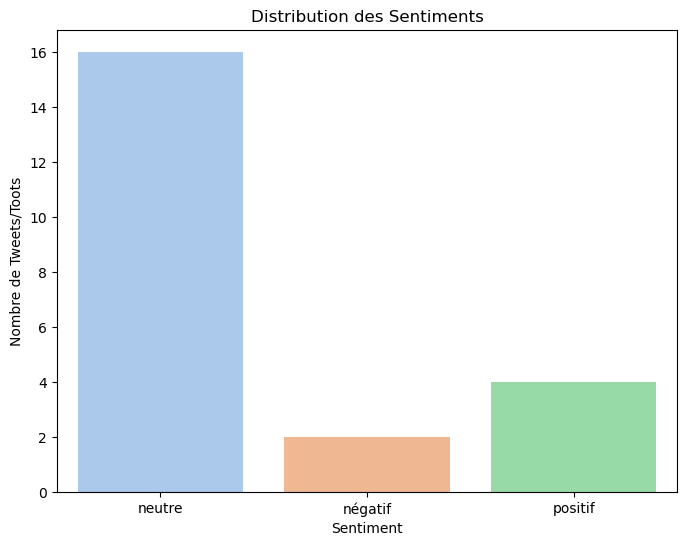

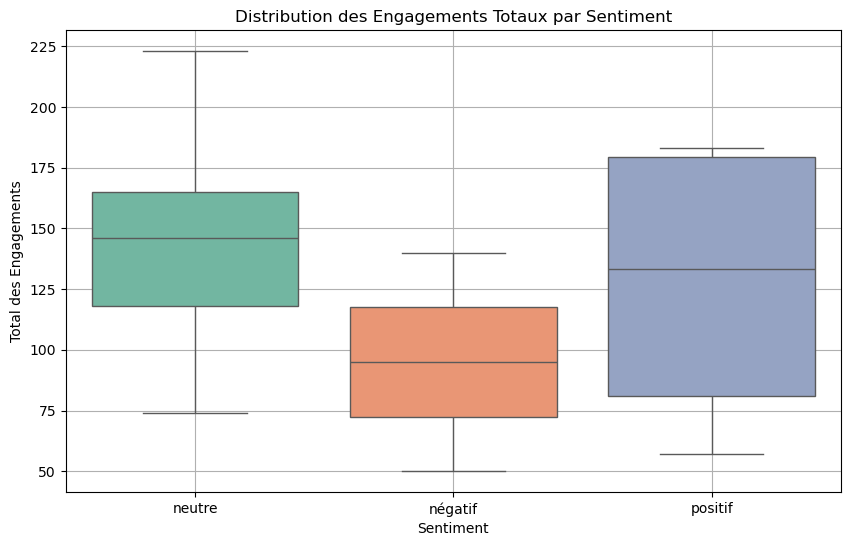

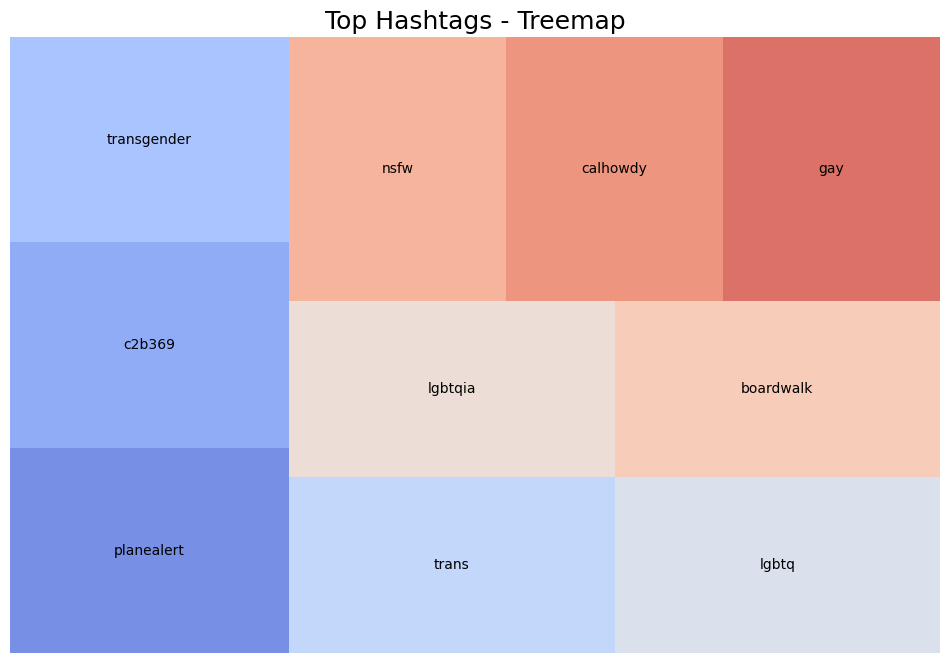

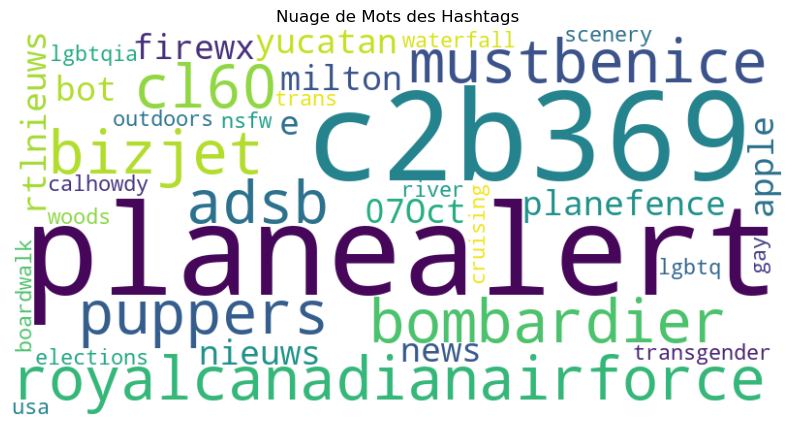

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from wordcloud import WordCloud
import os
import squarify

# 1. Création d'une session Spark
spark = SparkSession.builder \
    .appName("Gold Mastodon Data Retrieval") \
    .getOrCreate()

# 2. Définir les paramètres JDBC pour la connexion à la base PostgreSQL
jdbc_url = "jdbc:postgresql://postgres:5432/" + os.getenv('DB_NAME')
properties = {
    "user": os.getenv('DB_USER'),
    "password": os.getenv('DB_PASSWORD'),
    "driver": "org.postgresql.Driver"
}

# 3. Lire toutes les données de la table 'gold_mastodon'
gold_mastodon_df = spark.read.jdbc(url=jdbc_url, table="gold_mastodon", properties=properties)

# 4. Convertir le DataFrame Spark en DataFrame Pandas
gold_mastodon_pd_df = gold_mastodon_df.toPandas()

# 5. Visualisation des données

# Fonction pour créer un nuage de mots à partir des hashtags
def plot_wordcloud(df):
    # Compter les hashtags, en excluant les valeurs nulles, vides, ou les listes vides
    hashtags_series = df['hashtags'].str.split(',').explode()
    hashtags_series = hashtags_series.dropna().str.strip()  # Exclure les valeurs nulles et enlever les espaces
    hashtags_series = hashtags_series[hashtags_series != ""]  # Exclure les chaînes vides
    hashtags_series = hashtags_series[hashtags_series != "[]"]  # Exclure les listes vides

    # Vérifier si des hashtags existent avant de générer le nuage de mots
    if not hashtags_series.empty:
        hashtags_text = ' '.join(hashtags_series)
        
        # Générer le nuage de mots
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(hashtags_text)
        
        # Afficher le nuage de mots
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')  # Ne pas afficher les axes
        plt.title('Nuage de Mots des Hashtags')
        plt.show()
    else:
        print("Aucun hashtag disponible pour générer le nuage de mots.")

# Top Hashtags
def treemap_top_hashtags(df):
    # Extraire et compter les hashtags
    hashtags_series = df['hashtags'].str.split(',').explode()
    hashtags_series = hashtags_series.dropna().str.strip()  # Exclure les valeurs nulles et enlever les espaces
    hashtags_series = hashtags_series[hashtags_series != ""]  # Exclure les chaînes vides
    hashtags_series = hashtags_series[hashtags_series != "[]"]  # Exclure les listes vides
    
    # Obtenir les 10 hashtags les plus fréquents
    top_hashtags = hashtags_series.value_counts().head(10)
    
    # Vérifier s'il y a des hashtags à visualiser
    if not top_hashtags.empty:
        # Préparer les données pour le treemap
        tailles = top_hashtags.values
        etiquettes = top_hashtags.index
        
        # Créer le treemap
        plt.figure(figsize=(12, 8))
        squarify.plot(sizes=tailles, label=etiquettes, alpha=0.8, color=sns.color_palette("coolwarm", len(etiquettes)))
        
        # Ajouter un titre au graphique
        plt.title('Top Hashtags - Treemap', fontsize=18)
        plt.axis('off')  # Désactiver les axes
        
        # Afficher le graphique
        plt.show()
    else:
        print("Aucun hashtag disponible pour générer le treemap.")

# Distribution des sentiments
def plot_sentiment_distribution(df):
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='sentiment_category', hue='sentiment_category', palette='pastel', legend=False)
    plt.title('Distribution des Sentiments')
    plt.xlabel('Sentiment')
    plt.ylabel('Nombre de Tweets/Toots')
    plt.show()

def plot_engagement_by_sentiment(df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='sentiment_category', y='total_engagement', hue='sentiment_category', palette='Set2', legend=False)
    plt.title('Distribution des Engagements Totaux par Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Total des Engagements')
    plt.grid(True)
    plt.show()

def plot_average_engagement_per_user(df):
    user_engagement = df.groupby('username')['average_engagement_per_post'].mean().sort_values(ascending=False).head(20)  # Top 20 utilisateurs
    plt.figure(figsize=(12, 6))
    sns.barplot(x=user_engagement.values, y=user_engagement.index, hue=user_engagement.index, palette='Blues_d', legend=False)
    plt.title('Engagement Moyen par Utilisateur (Top 20)')
    plt.xlabel('Engagement Moyen')
    plt.ylabel('Utilisateur')
    plt.show()

# Appel des fonctions pour générer les visualisations
plot_average_engagement_per_user(gold_mastodon_pd_df)
plot_sentiment_distribution(gold_mastodon_pd_df)
plot_engagement_by_sentiment(gold_mastodon_pd_df)
treemap_top_hashtags(gold_mastodon_pd_df)
plot_wordcloud(gold_mastodon_pd_df)

# Arrêter la session Spark
spark.stop()